In [1]:
import sys
import pickle
import pandas as pd
import matplotlib
import graph_tool.all as gt

print(f"Python:      {sys.version}")
print("Package versions:")
print(f"pandas:      {pd.__version__}")
print(f"matplotlib:  {matplotlib.__version__}")
print(f"graph-tool:  {gt.__version__}")

Python:      3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:02:48) [Clang 18.1.8 ]
Package versions:
pandas:      2.2.3
matplotlib:  3.10.1
graph-tool:  2.92 (commit , )


In [2]:
graph_short_names = ["Karate", "Student", "Jazz", "FB", "FB1", "NetSci"]

In [3]:
# karate — Zachary Karate Club, URL: https://networks.skewed.de/net/karate
karate = gt.collection.ns["karate/78"]
# student_cooperation — Student cooperation (2012), URL: https://networks.skewed.de/net/student_cooperation
student = gt.collection.ns["student_cooperation"]
# jazz_collab — Jazz collaboration network, URL: https://networks.skewed.de/net/jazz_collab
jazz = gt.collection.ns["jazz_collab"]
# facebook_friends — Maier Facebook friends (2014), URL: https://networks.skewed.de/net/facebook_friends
facebook = gt.collection.ns["facebook_friends"]
# facebook_organizations — Within-organization Facebook friendships (2013), URL: https://networks.skewed.de/net/facebook_organizations
FB1 = gt.collection.ns["facebook_organizations/S1"]
# netscience — Scientific collaborations in network science (2006), URL: https://networks.skewed.de/net/netscience
netsci = gt.collection.ns["netscience"]

graphs = [karate, student, jazz, facebook, FB1, netsci]

In [4]:
import matplotlib.pyplot as plt

def get_largest_component_from_gt(g: gt.Graph, label: str) -> gt.Graph:
    print(f"Processing {label}...")
    if g.is_directed():
        raise ValueError("This function only supports undirected graphs.")

    lc_g = gt.extract_largest_component(g)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    gt.graph_draw(g, output_size=(300,300), bg_color="white", mplfig=ax[0]);
    gt.graph_draw(lc_g, output_size=(300,300), bg_color="white", mplfig=ax[1]);
    ax[0].set_title("Input graph")
    ax[1].set_title("Largest component")
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    plt.show()
    return lc_g

Processing Karate...


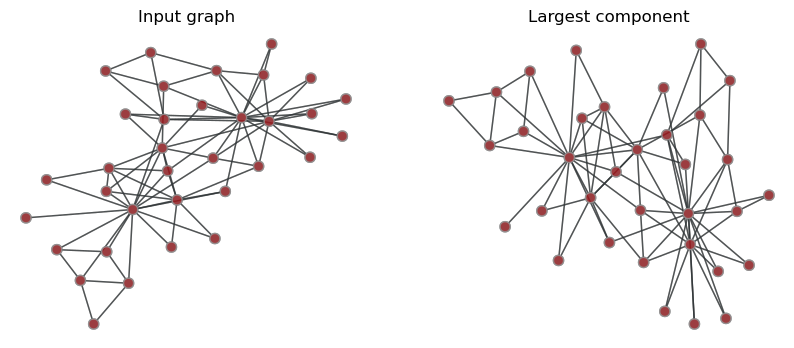

Processing Student...


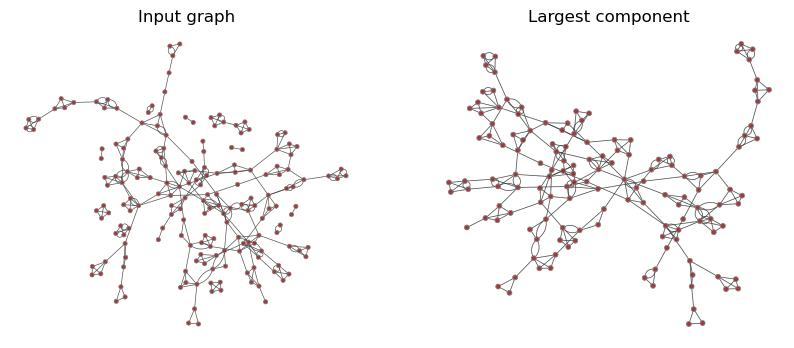

Processing Jazz...


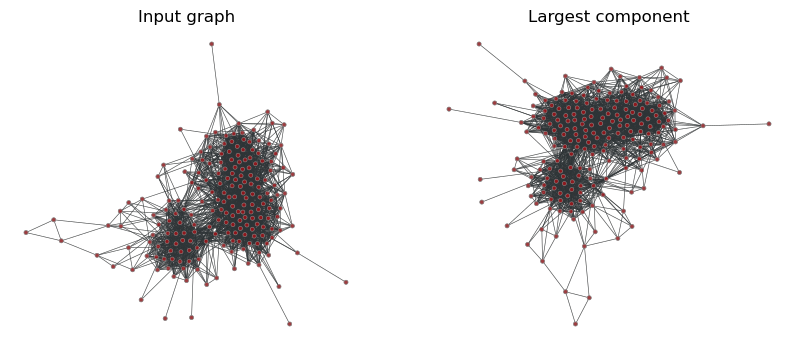

Processing FB...


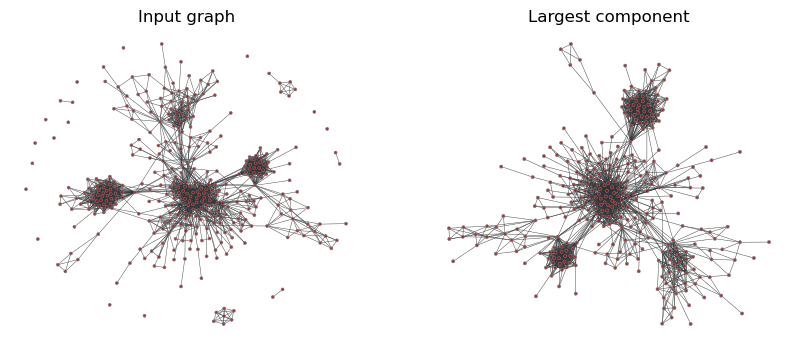

Processing FB1...


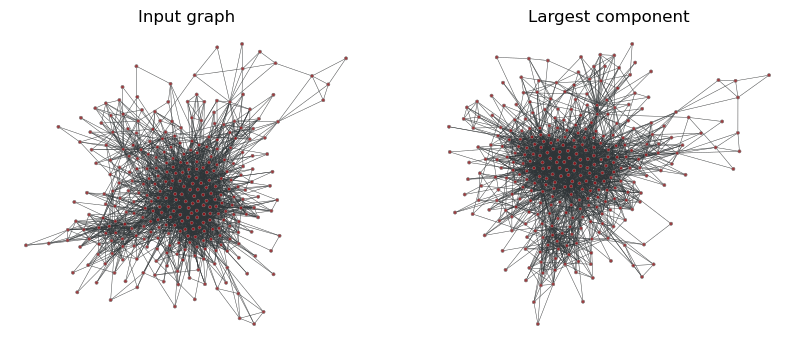

Processing NetSci...


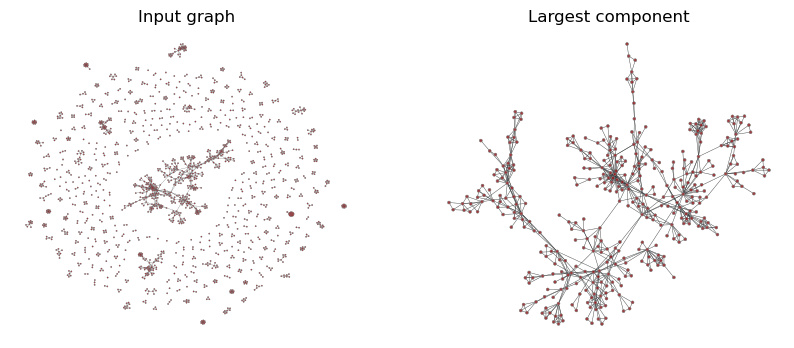

In [5]:
graphs_lc = {}
for name, g in zip(graph_short_names, graphs):
    graphs_lc[name] = get_largest_component_from_gt(g, name)

In [9]:
def network_stats(g: gt.Graph) -> dict:
    """
    Compute basic statistics of the graph g.
    """
    n_nodes = g.num_vertices()
    n_edges = g.num_edges()
    density = 2 * n_edges / (n_nodes * (n_nodes - 1))
    avg_degree, avg_degree_std = gt.vertex_average(g, "total")
    k_max = g.get_total_degrees(g.get_vertices()).max()
    diameter = gt.pseudo_diameter(g)[0]
    global_clustering = gt.global_clustering(g, sampled=True)
    return {
        "Nodes": n_nodes,
        "Edges": n_edges,
        "density": density,
        "<k>": avg_degree,
        "k_std": avg_degree_std,
        "k_max": k_max,
        "diameter": diameter,
    }

In [10]:
df = pd.DataFrame({label: network_stats(g) for label, g in graphs_lc.items()}).T
df.to_csv("out/network_stats.csv")
df

,Nodes,Edges,density,<k>,k_std,k_max,diameter
Karate,34.0,78.0,0.139037,4.588235,0.655186,17.0,5.0
Student,141.0,297.0,0.030091,4.212766,0.139991,10.0,17.0
Jazz,198.0,2742.0,0.140594,27.696970,1.237300,100.0,6.0
FB,329.0,1954.0,0.036215,11.878419,0.603350,63.0,9.0
FB1,320.0,2369.0,0.046415,14.806250,0.797175,113.0,7.0
NetSci,379.0,914.0,0.012760,4.823219,0.201725,34.0,17.0


In [11]:
# convert each network to scipy.sparse.csr_matrix（shape = (N, N)）
graph_adj_csr = {}
for label, g in graphs_lc.items():
    graph_adj_csr[label] = gt.adjacency(g)

In [12]:
# save to a pickle file
with open("data/graph_adj_csr.pkl", "wb") as f:
    pickle.dump(graph_adj_csr, f)